In [1]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
import random
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model 
%matplotlib inline

In [2]:
import glob 
import pandas as pd 
import re 
import time 
import itertools 
import seaborn as sns  
import keras 
import datetime

from numpy import expand_dims
from keras import callbacks 
from keras import layers
from keras.layers.normalization import BatchNormalization 
from keras import backend as k 
from keras import regularizers  
from keras.layers import Activation, add, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D, Reshape, ZeroPadding2D, AveragePooling2D 
from keras.layers.convolutional import UpSampling2D 
from keras.losses import binary_crossentropy 
from keras.models import Model, Sequential 
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical, plot_model 
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix 
from timeit import default_timer as timer
from keras.models import Model
from keras.initializers import glorot_uniform

In [3]:
from keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [5]:
ROWS = 224
COLS = 224
CHANNELS = 3
CLASSES = 30

In [6]:
def read_image(file_path): # Read images and convert it into the uniform size (224x224x3)
    img_start = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img_start, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [7]:
filenames= os.listdir ('./images')
x_train = []
y_train = []
for folder in filenames: # Read the file name.
    for image in os.listdir(f'./images/{folder}'):# Use folder as parameter.
        img = read_image(f'./images/{folder}/{image}') # Read the files in each folder.
        x_train.append(img) # Append them (the file and label) in exact same order.
        y_train.append(folder)

In [8]:
c = list(zip(x_train, y_train)) # build the relationship between image and label
random.shuffle(c) # shuffle
a, b = zip(*c) # get image and label back (the order of rows is changed but the label is always attached to image)

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [10]:
label_encoder.fit(["African elephant", "ant", "asparagus", "bridge", "computer keyboard","cow","dining table","Ferris wheel","flower","French bulldog","gas pump","gorilla","hula-hoop","jelly bean","jellyfish","king penguin","kiwi","koala","limousine","monarch","motorcycling","rodent","roller coaster","seashore","sea slug","sewing machine","skyscraper","snail","tiger","wasp's nest"])

LabelEncoder()

In [11]:
b_label = np.copy(b)
b_label = label_encoder.transform(b_label)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(a, b_label, train_size=0.8,test_size=0.2, random_state=101)

In [13]:
training_image = np.copy(X_train)
training_label = np.copy(y_train)
test_image = np.copy(X_test)
test_label = np.copy(y_test)

training_image = np.array(training_image)
training_label = np.array(training_label)
test_image = np.array(test_image)
test_label = np.array(test_label)

In [14]:
training_images_norm = cv2.normalize(training_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
testing_images_norm = cv2.normalize(test_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [15]:
x_label_OneHot = to_categorical(training_label, 30)
y_label_OneHot = to_categorical(test_label, 30)

In [16]:
print(np.shape(training_images_norm))

(24000, 224, 224, 3)


In [17]:
num_classes = 30
epochs = 100
num_checkpoints = 10
batch_size = 32
model_name = "resnet18"
verbosity = 1
params_conv2d = {
        "padding": "SAME",
        "activation": keras.activations.elu,
        "kernel_regularizer": keras.regularizers.l2(0.01)
}

In [18]:
x = keras.Input((224, 224, 3))

conv1 = keras.layers.Conv2D(filters=32, kernel_size=7, strides=1, **params_conv2d)(x)
conv1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv1)

max_pool = keras.layers.MaxPool2D(padding="SAME")(conv1)
conv2_1 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(max_pool)
conv2_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_1)
conv2_2 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(conv2_1)
conv2_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_2)
skip2_1 = keras.layers.BatchNormalization()(keras.layers.add([max_pool, conv2_2]))

conv2_3 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(conv2_2)
conv2_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_3)
conv2_4 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, **params_conv2d)(conv2_3)
conv2_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_4)

resize2 = keras.layers.Conv2D(filters=32, kernel_size=1, strides=2, padding="SAME")(skip2_1)
skip2_2 = keras.layers.BatchNormalization()(keras.layers.add([resize2, conv2_4])) 

conv3_1 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(skip2_2)
conv3_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_1)
conv3_2 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(conv3_1)
conv3_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_2)

resize3_1 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=1, padding="SAME")(skip2_2)
skip3_1 = keras.layers.BatchNormalization()(keras.layers.add([resize3_1, conv3_2]))

conv3_3 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(skip3_1)
conv3_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_3)
conv3_4 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, **params_conv2d)(conv3_3)
conv3_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_4)

resize3_2 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=2, padding="SAME")(skip3_1)
skip3_2 = keras.layers.BatchNormalization()(keras.layers.add([resize3_2, conv3_4]))

conv4_1 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(skip3_2)
conv4_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_1)
conv4_2 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(conv4_1)
conv4_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_2)

resize4_1 = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1, padding="SAME")(skip3_2)
skip4_1 = keras.layers.BatchNormalization()(keras.layers.add([resize4_1, conv4_2]))

conv4_3 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(skip4_1)
conv4_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_3)
conv4_4 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, **params_conv2d)(conv4_3)
conv4_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_4)

resize4_2 = keras.layers.Conv2D(filters=128, kernel_size=1, strides=2, padding="SAME")(skip4_1)
skip4_2 = keras.layers.BatchNormalization()(keras.layers.add([resize4_2, conv4_4]))

conv5_1 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(skip4_2)
conv5_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_1)
conv5_2 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(conv5_1)
conv5_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_2)

resize5_1 = keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding="SAME")(skip4_2)
skip5_1 = keras.layers.BatchNormalization()(keras.layers.add([resize5_1, conv5_2]))

conv5_3 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(skip5_1)
conv5_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_3)
conv5_4 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, **params_conv2d)(conv5_3)
conv5_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_4)

resize5_2 = keras.layers.Conv2D(filters=256, kernel_size=1, strides=2, **params_conv2d)(skip5_1)
skip5_2 = keras.layers.BatchNormalization()(keras.layers.add([resize5_2, conv5_4]))

avg_pool = keras.layers.AvgPool2D(strides=2)(skip5_2)
flat = keras.layers.Flatten()(avg_pool)
dense10 = keras.layers.Dense(30)(flat)
softmax = keras.layers.Softmax()(dense10)

model = keras.Model(inputs=x, outputs=softmax)

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 4736        input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 224, 224, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           spatial_dropout2d[0][0]          
_______________________________________________________________________________________

In [20]:
history = model.fit(training_images_norm, x_label_OneHot, batch_size=32, epochs=100,
                     validation_data=(testing_images_norm, y_label_OneHot), verbose=1)

Epoch 1/100
750/750 [==============================] - 67s 89ms/step - loss: 21.4503 - accuracy: 0.0434 - val_loss: 18.5378 - val_accuracy: 0.0888
Epoch 2/100
750/750 [==============================] - 65s 87ms/step - loss: 16.7110 - accuracy: 0.0706 - val_loss: 14.4151 - val_accuracy: 0.1375
Epoch 3/100
750/750 [==============================] - 67s 89ms/step - loss: 13.0665 - accuracy: 0.1217 - val_loss: 11.3396 - val_accuracy: 0.1853
Epoch 4/100
750/750 [==============================] - 66s 88ms/step - loss: 10.3732 - accuracy: 0.1606 - val_loss: 9.0456 - val_accuracy: 0.2302
Epoch 5/100
750/750 [==============================] - 66s 87ms/step - loss: 8.3297 - accuracy: 0.2023 - val_loss: 7.3321 - val_accuracy: 0.2558
Epoch 6/100
750/750 [==============================] - 66s 87ms/step - loss: 6.8388 - accuracy: 0.2311 - val_loss: 6.0567 - val_accuracy: 0.2875
Epoch 7/100
750/750 [==============================] - 65s 86ms/step - loss: 5.7398 - accuracy: 0.2511 - val_loss: 5.1093 -

In [21]:
_score_convolutional, _accuracy_convolutional = model.evaluate(testing_images_norm,
                                                               y_label_OneHot, verbose=0)
print('ResNet Accuracy on ImageNet without data-augmentation:', _accuracy_convolutional, '%')

ResNet Accuracy on ImageNet without data-augmentation: 0.5210000276565552 %


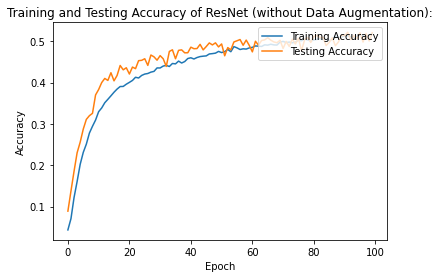

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Testing Accuracy of ResNet (without Data Augmentation):')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper right')
plt.show()

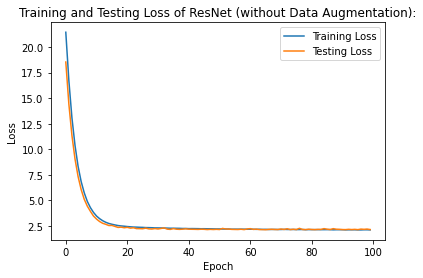

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Testing Loss of ResNet (without Data Augmentation):')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
                                                 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f'%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

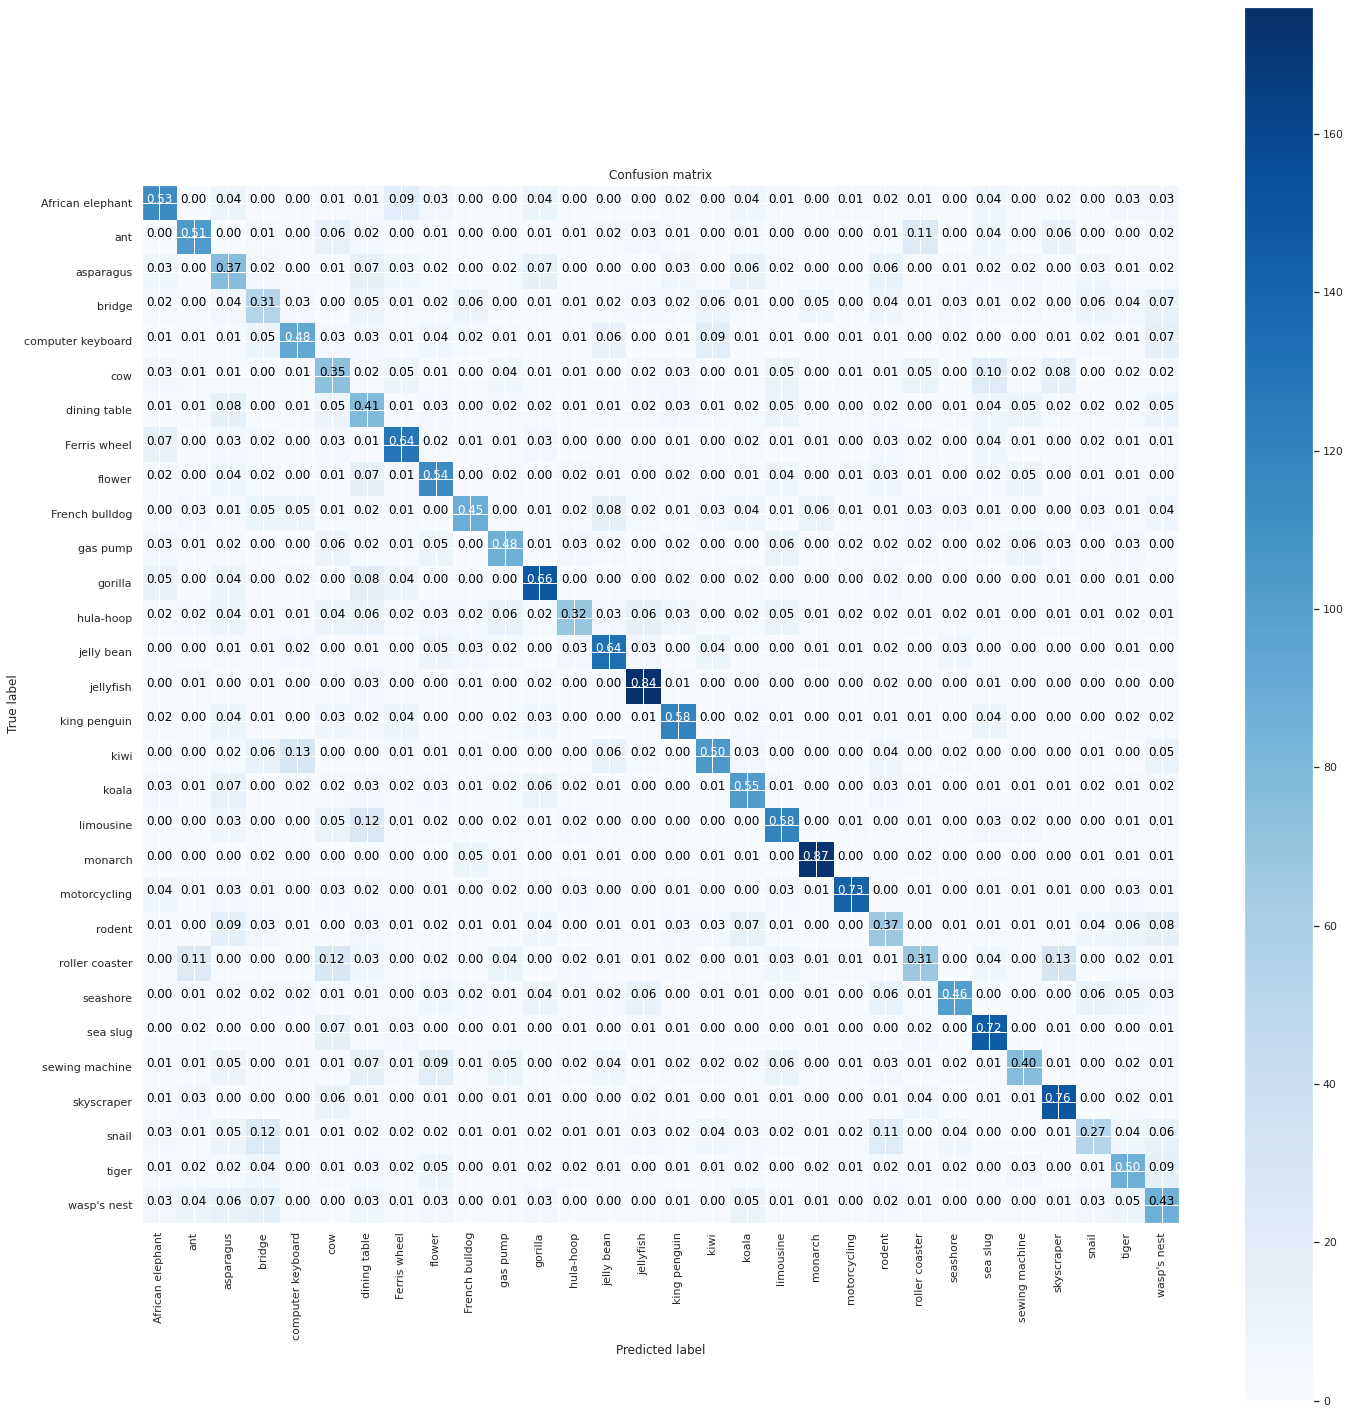

In [27]:
# Predict the values from the validation dataset
Y_pred = model.predict(testing_images_norm)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
confusion_mtx = confusion_matrix(test_label, Y_pred_classes) 
# plot the confusion matrix
plt.figure(figsize=(20,20))
sns.set(font_scale=1.0)
plot_confusion_matrix(confusion_mtx, classes = ["African elephant", "ant", "asparagus", "bridge", "computer keyboard","cow","dining table","Ferris wheel","flower","French bulldog","gas pump","gorilla","hula-hoop","jelly bean","jellyfish","king penguin","kiwi","koala","limousine","monarch","motorcycling","rodent","roller coaster","seashore","sea slug","sewing machine","skyscraper","snail","tiger","wasp's nest"])